## Example: MLM for ordinal data

In this example, we'll showcase the use of Matrix Linear Models (MLM) when dealing with ordinal data as predictors, specifically when the differences between sequential levels of the variable are of interest. To illustrate this, we'll create a simulated dataset where our X matrix comprises a single ordinal variable, 'catvar'. This variable ranges from 1 to 5. This simple setup will provide a clear demonstration of how MLM can handle ordinal data.

Just as a quick recap, our model formula is:

$$Y = XBZ^T+E$$

In this equation:

- $Y_{n \times m}$ is the response matrix
- $X_{n \times p}$ is the matrix for main predictors,
- $Z_{m \times q}$ denote the response attributes matrix based on a supervised knowledge,
- $E_{n \times m}$ is the error term, 
- $B_{p \times q}$ is the matrix for main and interaction effects.

This model formulation concisely summarizes the interactions between various elements in the matrix linear model framework.


### Data Generation

Our dataset is made up of a dataframe `X` that includes a single predictor. This predictor is ordinal data with `5 levels`, distributed over `n = 100` samples. Next, we define a response dataframe `Y` that consists of `m = 250` responses. 
In order to simulate the `Y` data, we need to construct the matrices `Z`, `B`, and `E`.
The `Z` matrix imparts information about the response population, represented by the columns of `Y`, $y_{i \in [1, 250]}$. This matrix is given dimensions of `250x4`.

In accordance with this configuration, our coefficient matrix `B` is set to have dimensions of `4x5`, aligning with the number of predictors in the design matrix `X` and the number of information categories in `Z`.

Lastly, we formulate the noise matrix E that accommodates the error terms. This matrix is produced as a normally-distributed matrix ($N, 0, 1$), introducing a degree of variability into our simulation.

In [279]:
using MatrixLM, DataFrames, Random, Plots, StatsModels, Statistics
Random.seed!(1)

# Dimensions of matrices 
n = 100
m = 250

# Number of groupings designed in the Z matrix
q = 4

# Generate data with 1 ordinal categorical variable.
dfX = DataFrame(catvar=rand(1:5, n));
levels_catvar = sort(unique(dfX.catvar));

To derive the predictor design matrix, we employ the `design_matrix()` function and apply contrast coding using the `SeqDiffCoding()` system. This particular coding system codes  is particularly useful for testing hypotheses related to "sequential differences" between the levels of our ordinal predictor.

In [280]:
X_ctrst = Dict(
             :catvar => SeqDiffCoding(levels = levels_catvar),
           )
           
X = design_matrix(@mlmformula(1 + catvar), dfX, X_ctrst);
p = size(X, 2);

The design matrix `X` has `p = 5` columns defined as:

In [281]:
X_names = MatrixLM.design_matrix_names(@mlmformula(1 + catvar), dfX, X_ctrst)

5-element Vector{String}:
 "(Intercept)"
 "catvar: 2"
 "catvar: 3"
 "catvar: 4"
 "catvar: 5"

We randomly generate a dataframe `Z` that provides information about whether a response $y_{i \in [1, 250]}$, i.e. column of `Y`, exhibits one of the four mutually exclusive attributes `{"A", "B", "C", "D"}`. To extract the design matrix of this "column predictor", we use the `design_matrix()` function and implement contrast coding with the `FullDummyCoding()` system.

The `FullDummyCoding` system generates one indicator (1 or 0) column for each level, including the base level. This technique is sometimes referred to as one-hot encoding, which is widely used for categorical variables.

In [282]:
dfZ = DataFrame(attribute= rand(["A", "B", "C", "D"], m))
Z_ctrst = Dict(
             :attribute => StatsModels.FullDummyCoding(),
          )
           
Z = design_matrix(@mlmformula(0 + attribute), dfZ, Z_ctrst);

The design matrix `Z` has `q = 4` columns defined as:

In [283]:
Z_names = MatrixLM.design_matrix_names(@mlmformula(0 + attribute), dfZ, Z_ctrst)

4-element Vector{Any}:
 "attribute: A"
 "attribute: B"
 "attribute: C"
 "attribute: D"

The error matrix `E` is obtained as follows:

In [284]:
E = randn(n,m).*4;

We intentionally structure the coefficient matrix `B` according to a distinct pattern. By doing so, we enable a more straightforward visualization and interpretation of the results in the following steps:

In [285]:
# (p,q)
B = [
    20.0  10.0 15.0 12.0;
    0.01  7.0  0.05 0.01;
    12.0  0.1  0.05 0.5;
    0.01  12.0 0.05 0.03;
    0.07  0.0  8.5  0.04;
];

Generate the response matrix `Y`:

In [286]:
Y = X*B*Z' + E;

Now, construct the `RawData` object consisting of the response variable `Y` and row/column predictors `X` and `Z`. All three matrices must be passed in as 2-dimensional arrays. You have the option to specify if `X` and `Z` include an intercept (true) or not (false). If this information is not provided, the default setting is assumed to be false (no intercept).

In [287]:
# Construct a RawData object
dat = RawData(Response(Y), Predictors(X, Z, true, false));

### Model estimation

Least-squares estimates for matrix linear models can be obtained by running `mlm`. An object of type `Mlm` will be returned, with variables for the coefficient estimates (`B`), the coefficient variance estimates (`varB`), and the estimated variance of the errors (`sigma`). By default, `mlm` estimates both row and column main effects (X and Z intercepts), but this behavior can be suppressed by setting `addXIntercept=false` and/or `addZIntercept=false`. Column weights for `Y` and the target type for variance shrinkage<sup>[1](#myfootnote1)</sup> can be optionally supplied to `weights` and `targetType`, respectively. 

In [288]:
est = mlm(dat; addXIntercept=false, addZIntercept=false); # Model estimation

### Model predictions and residuals

The coefficient estimates can be accessed using `coef(est)`. Predicted values and residuals can be obtained by calling `predict()` and `resid()`. By default, both of these functions use the same data used to fit the model. However, a new `Predictors` object can be passed into `predict()` as the `newPredictors` argument and a new `RawData` object can be passed into `resid()` as the newData argument. For convenience, `fitted(est)` will return the fitted values by calling predict with the default arguments.

In [289]:
esti_coef = coef(est); # Get the coefficients of the model

To compare the estimated coefficients with the original matrix `B`, we will visualize the matrices using heatmaps. This graphical representation allows us to readily see differences and similarities between the two.

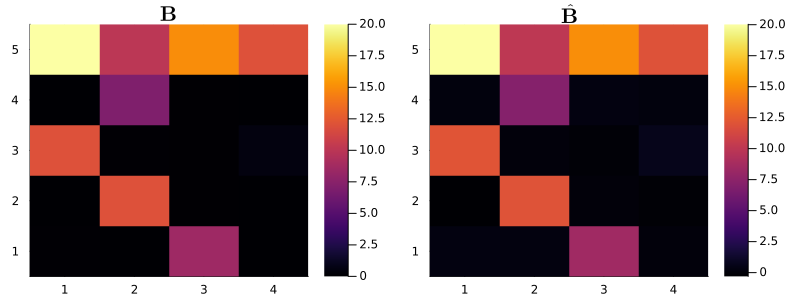

In [290]:
plot(
    heatmap(B[end:-1:1, :], 
            size = (800, 300)),     
    heatmap(esti_coef[end:-1:1, :], 
            size = (800, 300)),     
    title = ["\$ \\mathbf{B}\$" "\$ \\mathbf{\\hat{B}}\$"]
)



Let's employ the same visualization method to compare the predicted values with the original `Y` response matrix. This allows us to gauge the accuracy of our model predictions.

In [291]:
preds = predict(est); # Prediction value

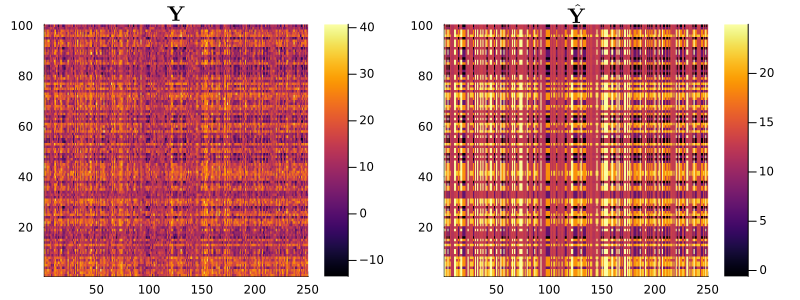

In [292]:
plot(
    heatmap(Y[end:-1:1, :], 
            size = (800, 300)),     
    heatmap(preds.Y[end:-1:1, :], 
            size = (800, 300), 
            # clims = (-2, 8)
            ),     
    title = ["\$ \\mathbf{Y}\$" "\$ \\mathbf{\\hat{Y}}\$"]
)

The `resid()` function, available in `MatrixLM.jl`, provides us with the ability to compute residuals for each observation, helping you evaluate the discrepancy between the model's predictions and the actual data.

In [293]:
resids = resid(est);

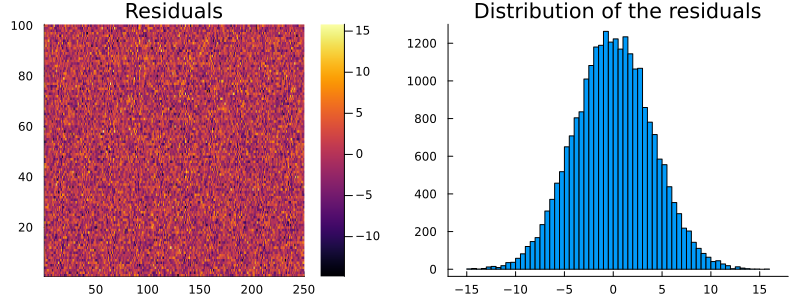

In [294]:
plot(
    heatmap(resids[end:-1:1, :], 
            size = (800, 300)),     
    histogram(
        (reshape(resids,250*100,1)),
            grid  = false,
            label = "",
            size = (800, 300)),     
    title = ["Residuals" "Distribution of the residuals"]
)

### T-statistics and permutation test

The t-statistics for an `Mlm` object (defined as `est.B ./ sqrt.(est.varB)`) can be obtained by running `t_stat`. By default, `t_stat` does not return the corresponding t-statistics for any main effects that were estimated by `mlm`, but they will be returned if `isMainEff=true`.

In [295]:
tStats = t_stat(est);

Permutation p-values for the t-statistics can be computed by the `mlm_perms` function. `mlm_perms` calls the more general function `perm_pvals` and will run the permutations in parallel when possible. The illustrative example below only runs 5 permutations, but a different number can be specified as the second argument. By default, the function used to permute `Y` is `shuffle_rows`, which shuffles the rows for `Y`. Alternative functions for permuting `Y`, such as `shuffle_cols`, can be passed into the argument `permFun`. `mlm_perms` calls `mlm` and `t_stat` , so the user is free to specify keyword arguments for `mlm` or `t_stat`; by default, `mlm_perms` will call both functions using their default behavior.

In [296]:
nPerms = 500
tStats, pVals = mlm_perms(dat, nPerms, addXIntercept=false, addZIntercept=false);

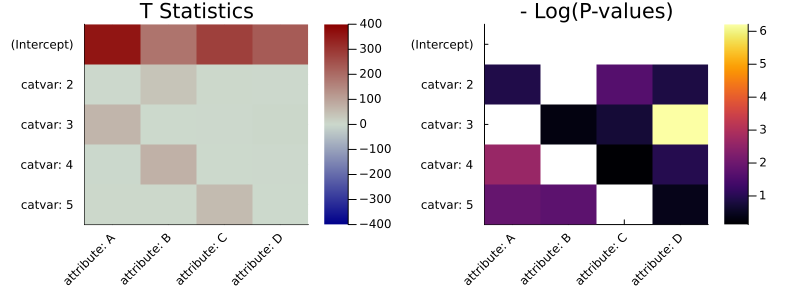

In [300]:
plot(
    heatmap(tStats[end:-1:1, :],
            c = :bluesreds,
            clims = (-400, 400),
            xticks = (1:4, Z_names),
            xrotation = 45,
            yticks = (collect(5:-1:1), X_names),
            bottom_margin = (10, :mm),
            size = (800, 300)),  
    heatmap(-log.(pVals[end:-1:1, :]),
            grid = false,
            xticks = (1:4, Z_names),
            xrotation = 45,                            
            yticks = (collect(5:-1:1), X_names),
            bottom_margin = (10, :mm),
            size = (800, 300)),       
    title = ["T Statistics" "- Log(P-values)"]
)


In this example, our interpretation of the results can be as follows: 
- the responses $y_{i \in [1, 250]}$ that exhibit the "A" attribute in `Z` show significant differences between level 3 and level 2 of the predictor `catvar` in `X`.
- the responses $y_{i \in [1, 250]}$ that exhibit the "B" attribute in `Z` show significant differences between level 4 and level 3, as well as between level 2 and level 1 of the predictor `catvar` in `X`.
- the responses $y_{i \in [1, 250]}$ that exhibit the "C" attribute in `Z` show significant differences between level 5 and level 4 of the predictor `catvar` in `X`.

---

<a name="myfootnote1">1</a>. Ledoit, O., & Wolf, M. (2003). Improved estimation of the covariance matrix of stock returns with an application to portfolio selection. Journal of empirical finance, 10(5), 603-621. 